<a href="https://colab.research.google.com/github/wqiu96/summer_project/blob/master/src/value_iter_dirichlet_2d_fin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import time
start_time = time.time()
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

__Goal__

Implement value iteration on 1d HJB with Dirichlet data and verify with the explicit solution on Whittle’s “Flypaper”

__Ref__

- [1] Chap V.7 of [Roger and Williams 2000] 

- [2] P97, Example 4 of [Kushner and Dupuis 2001]

- [previous version](https://github.com/songqsh/foo1/blob/master/src/value_iter_dirichlet_1d.ipynb)


__Problem setup__

We want to solve a d-dimensions HJB
$$\inf_a \{\sum_{i=1}^db_i(x,a)  \frac{\partial v(x)}{\partial x_i}  + \frac 1 2 \sum_{i,j=1}^{d} \hat \sigma_{ij} \frac{\partial^2 v(x)}{\partial x_i \partial x_j} - \lambda v(x) + \ell(x,a)\} = 0, \quad \hbox{ where } \hat \sigma _{ij} = \sigma*\sigma^T , \sum_{i=1}^{d}x_i^2\leq1$$
with Dirichlet data
$$v(x_1,x_2,..,x_d) = g(x_1,x_2,..,x_d), \quad \hbox{ when } \sum_{i=1}^{d}x_i^2 = 1$$




__MDP discretization__

Approximation:
$$
\frac{\partial v(x)}{\partial x_i} \leftarrow \frac{v(x+e_ih)-v(x-e_ih)}{2h}
$$
when $i = j$
$$
\frac{\partial^2 v(x)}{\partial x_i^2} \leftarrow \frac{v(x+e_ih)-2v(x)+v(x-e_ih)}{h^2}
$$
when $i \neq j$
$$
\frac{\partial^2 v(x)}{\partial x_i^2} \leftarrow \frac{v(x+e_ih+e_jh)-v(x+e_ih-e_jh)-v(x-e_ih+e_jh)+v(x-e_ih-e_jh)}{4h^2}
$$
then
$$\inf_a \{v(x)(-\lambda-\sum_{i=1}^{d}\frac{\hat \sigma_{ii}}{h^2})+\sum_{i=1}^{d}v(x+e_ih)\frac{b_i(x,a)h+\sigma_{ii}}{2h^2}+\sum_{i=1}^{d}v(x-e_ih)\frac{-b_i(x,a)h+\sigma_{ii}}{2h^2}+    \\
\sum_{i,j=1,i\neq j}^{d}(v(x+e_ih+e_jh)-v(x+e_ih-e_jh)-v(x-e_ih+e_jh)+v(x-e_ih-e_jh))\frac{\hat \sigma_{ij}}{8h^2}+ \ell(x,a)\} = 0
$$
Set
$$
c_1 = \lambda+\sum_{i=1}^{d}\frac{\hat \sigma_{ii}}{h^2}
$$
$$
\Lambda = \frac{\sum_{i=1}^{d}\frac{\lambda h^2+\sigma_{ii}}{h^2}}{\sum_{i=1}^{d}\frac{\sigma_{ii}}{h^2}}=\frac{\lambda h^2+\sum_{i=1}^{d}{\sigma_{ii}}}{\sum_{i=1}^{d}\sigma_{ii}}
$$
Then
$$
p^h(x+e_ih|x_i, a_i) = \Lambda \cdot (\frac{b_i(x,a)h + \hat \sigma_{ii}}{2c_1h^2})
$$
$$
p^h(x-e_ih|x_i, a_i) = \Lambda \cdot (\frac{-b_i(x,a)h + \hat \sigma_{ii}}{2c_1h^2})
$$
$$
p^h(x \pm e_ih \pm e_jh|x_i, x_j) = \frac{\hat \sigma_{ij}}{8h^2}
$$
$$
 \hat \ell(x,a)=\frac{\ell(x,a)}{c_1}
$$
so 

$$
v(x) = \inf_a\{\sum_{i=1}^{d}p^h(x+e_ih|x_i, a_i)v(x+e_ih) +\sum_{i=1}^{d}p^h(x-e_ih|x_i, a_i)v(x-e_ih) \\
+ \sum_{i,j=1,i\neq j}^{d}(v(x+e_ih+e_jh)-v(x+e_ih-e_jh)-v(x-e_ih+e_jh)+v(x-e_ih-e_jh))p^h(x \pm e_ih \pm e_jh|x_i, x_j) + \hat \ell(x,a) \}
$$

__Example__
$$
\inf_a(a \bigtriangledown v + \frac 1 2 \bigtriangleup v +d + 2|x|^2 + \frac 1 2 |a| ^2)
$$

where
$$
v(x) = g(x) = -|x|^2 = -(x_1^2 + x_2^2 +...+x_d^2)\\
$$
In this case
$$
b(x,a) = (a_1, a_2,...,a_d) \\
\begin{equation*}
\hat \sigma =\begin{bmatrix}
1 & 0&\dots & 0\\
0 &1 &\dots &0\\
0 & 0 &\dots & 1
\end{bmatrix}_{d\times d}
\end{equation*}
$$
$$
\ell(x,a) = d + 2|x|^2 + \frac 1 2 |a|^2
$$
the exact solution is 
$$
v(x) =  -|x|^2 = -(x_1^2 + x_2^2 +...+x_d^2)
$$

__Rk__

There is essential difference of above MDP approximation using central FDM from the one
using upward FDM provided by P97 of [2].

In [0]:
#PDE to be solved
class pde:
  def __init__(self):
    #pde config
    self.name = 'HJB nd'
    self.dim = 2
    self.LIM = 1 #limit for state

    self.lambda_ = 0. #discount rate
    self.sigma = np.eye(self.dim) #diffusion coefficient matrix
 
    self.drift = lambda x,a: a  #drift coefficient function

    self.run_cost = lambda x, a: self.dim + 2*sum([i**2 for i in x]) + (1/2)*sum([j**2 for j in a])

    self.term_cost = lambda x: -sum([i**2 for i in x])
    
    #pde exact solution if available
    self.exact_sol = self.term_cost

    

In [0]:
def mdp_space_config(self, 
                     dim = 2,
                     NUM = 5 #num of meshes in one unit state space
                    ):
  self.NUM = NUM
  
  self.dim = dim
  
  self.h = 1./self.NUM #mesh size in state space
  
  self.LIM = 1
  
  self.x_space = np.array([i*self.h for i in range(-self.NUM*self.LIM, (self.NUM+1)*self.LIM)])
  #self.x_space = np.arange(-self.LIM, self.LIM, self.h)  # x state space, for all dimensions, x_d have the same range
  #self.x_space = np.repeat(np.expand_dims(space, axis = 0) ,self.dim , axis = 0) # x state space
  
  #self.a_space = np.arange(-2*self.LIM, 2*self.LIM + self.h, self.h) #action space
  self.a_space = np.array([i*self.h for i in range(-self.NUM*self.LIM, (self.NUM+1)*self.LIM)]) #when the a_space is as large as x_space, the result is best.why?
  self.del_ind_space = np.array([-1,1]) #space of delta (1-step) index: -1 means left, 1 means right move

  #q-table and state value initialization
  #self.s_val = np.ones(self.x_space.size*np.ones(self.dim, np.int))
  self.s_val = np.random.random(self.x_space.size*np.ones(self.dim, np.int))
  self.q_table = np.random.random(self.a_space.size*np.ones(self.dim, np.int))
  
  print('>>>>> q_table size is %i' %(self.q_table.size))

  #s_val and q-table terminal setup
  for i in range(self.s_val.size):  # visit all x States
    k = self.dim - 1
    x_d = []          
    s_index = []
    Limit = 0
    while k >= 0:
      x_d.append(self.x_space[(i//(self.x_space.size**k))%self.x_space.size])
      s_index.append((i//(self.x_space.size**k))%self.x_space.size)
      Limit += self.x_space[(i//(self.x_space.size**k))%self.x_space.size]**2
      k -= 1
    if (0 in s_index) or ((len(self.x_space) - 1) in s_index): # visit the terminal condition 
      self.s_val[tuple(s_index)] = self.term_cost(x_d)
  
  
pde.mdp_space_config = mdp_space_config

In [0]:
#transition probability
#output is probability (np array) on del_ind_space 
#central fdm

def mdp_trans_prob_central(self,x,a,sigma):
  tp = []
  b_ = self.drift(x,a)
  
  c1 = self.lambda_ + sum(sigma.diagonal())/(self.h**2)
  Lambda = 1 + self.lambda_*(self.h**2)/sum(self.sigma.diagonal())
  
  tp.append(Lambda*((b_*self.h + sigma.diagonal())/(2*c1*self.h**2)))
  tp.append(Lambda*((-1*b_*self.h + sigma.diagonal())/(2*c1*self.h**2)))
  tp.append(sigma/(8*c1*self.h**2))
  
  #correction on prob
#  if tp[1]<0:
#    tp = tp - tp[1]
#    tp = tp/tp.sum()
#    print('>>>>corrected probability due to negativity')

  return tp  

pde.mdp_trans_prob_central = mdp_trans_prob_central

In [0]:
def Dif_array(self,s_index):        #calculate s_val(x+e_i*h) and s_val(x-e_i*h)
  res_plus = np.zeros(self.dim)
  res_mius = np.zeros(self.dim)
  for i in range(self.dim):
    temp_plus = s_index.copy() #copy()!!!!!!! very important
    temp_mius = s_index.copy()
    temp_plus[i] = s_index[i] + 1
    temp_mius[i] = s_index[i] - 1
    res_plus[i] = self.s_val[tuple(temp_plus)]
    res_mius[i] = self.s_val[tuple(temp_mius)]
  return res_plus,res_mius

pde.Dif_array = Dif_array

In [0]:
def Dif_martix(self,s_index):        #calculate s_val(x+e_i*h-e_j*h), s_val(x-e_j*h+e_i*h), s_val(x+e_j*h+e_i*h), s_val(x-e_j*h-e_i*h)
  res_plus_plus = np.zeros((self.dim,self.dim))
  res_mius_mius = np.zeros((self.dim,self.dim))
  res_plus_mius = np.zeros((self.dim,self.dim))
  res_mius_plus = np.zeros((self.dim,self.dim))
  for i in range(self.dim):
    for j in range(self.dim):
      if i != j:
        temp_plus_plus = s_index.copy()
        temp_mius_mius = s_index.copy()
        temp_plus_mius = s_index.copy()
        temp_mius_plus = s_index.copy()
        
        temp_plus_plus[i] = s_index[i] + 1
        temp_plus_plus[j] = s_index[j] + 1
        
        temp_mius_mius[i] = s_index[i] - 1
        temp_mius_mius[j] = s_index[j] - 1
        
        temp_plus_mius[i] = s_index[i] + 1
        temp_plus_mius[j] = s_index[j] - 1
        
        temp_mius_plus[i] = s_index[i] - 1
        temp_mius_plus[j] = s_index[j] + 1

        res_plus_plus[i][j] = self.s_val[tuple(temp_plus_plus)]
        res_mius_mius[i][j] = self.s_val[tuple(temp_mius_mius)]
        res_plus_mius[i][j] = self.s_val[tuple(temp_plus_mius)]
        res_mius_plus[i][j] = self.s_val[tuple(temp_mius_plus)]
  res = res_plus_plus + res_mius_mius - res_plus_mius - res_mius_plus
  
  return res

pde.Dif_martix = Dif_martix

In [0]:
def value_iter(self, 
               TOL= 0.0001, #tolerance for iteration
               MAX_ITER= 2000 #maximum iteration
              ):
 
  err_ = 1. #error init
  
  n_iter = 0 #iteration counter

  while err_>TOL and n_iter < MAX_ITER:
    pre_s_val = self.s_val.copy()

    for i in range(self.s_val.size):  # visit all x States
      k = self.dim - 1
      x_d = []          
      s_index = []
      Limit = 0
      while k >= 0:
        x_d.append(self.x_space[(i//(self.x_space.size**k))%self.x_space.size])
        s_index.append((i//(self.x_space.size**k))%self.x_space.size)
        Limit += self.x_space[(i//(self.x_space.size**k))%self.x_space.size]**2
        k -= 1
      if (0 in s_index) or ((self.x_space.size - 1) in s_index):
        continue
      for j in range(self.a_space.size**self.dim):
        m = self.dim - 1
        a_index = []
        a_list = []
        while m >= 0:
          a_index.append((i//(self.a_space.size**m))%self.a_space.size)
          a_list.append(self.a_space[(i//(self.a_space.size**m))%self.a_space.size])
          m -= 1
        a_ = np.array(a_list)
        tp_ = self.mdp_trans_prob_central(x_d, a_, self.sigma)
        c1 = self.lambda_ + sum(self.sigma.diagonal())/(self.h**2)
        res_plus,res_mins = self.Dif_array(s_index)
        res = self.Dif_martix(s_index)

        run_cost_ = (self.run_cost(x_d,a_))/c1
        Lambda = 1 + self.lambda_*(self.h**2)/sum(self.sigma.diagonal())

        self.q_table[tuple(a_index)] = (run_cost_ + np.sum(np.multiply(tp_[0],res_plus)) + np.sum(np.multiply(tp_[1],res_mins))+np.sum(np.multiply(res,tp_[2])))/Lambda
      self.s_val[tuple(s_index)] = np.min(self.q_table) #sync q_table with s_val
      self.q_table = np.random.random(self.a_space.size*np.ones(self.dim, np.int))
    err_ = np.max(np.abs(pre_s_val - self.s_val))

    n_iter += 1
    if np.mod(n_iter,10) == 0:
      print('iterated ' + str(n_iter)+';')
      
  return [err_, n_iter]
      
pde.value_iter = value_iter      

In [8]:
pde1 = pde()
pde1.mdp_space_config(dim=2,NUM=10) #if NUM is chosen to be 20 or bigger number, the result is bad
err, n_iter = pde1.value_iter(TOL = 0.01, MAX_ITER = 1000)

>>>>> q_table size is 441
iterated 10;
iterated 20;


In [9]:
end_time = time.time()
print('elapsed time is %f seconds' %(end_time - start_time))

elapsed time is 283.645860 seconds


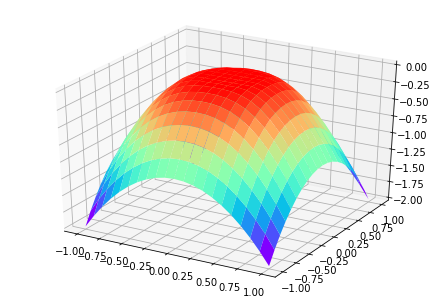

In [10]:
figure = plt.figure()
axes = Axes3D(figure)
X1 = pde1.x_space
X2 = pde1.x_space
X1, X2 = np.meshgrid(X1, X2)
Z1 = pde1.s_val
axes.plot_surface(X1, X2, Z1,cmap='rainbow')

>>>iteration error is 0.009244493662148828
>>>iter number is 25
>>>max norm of error is 0.17226488833257947
>>>Percentage of error is 0.10776846481801118


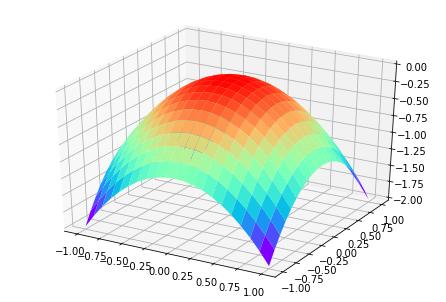

In [11]:
figure = plt.figure()
axes = Axes3D(figure)
X1 = pde1.x_space
X2 = pde1.x_space
X1, X2 = np.meshgrid(X1, X2)
Z = -(X1)**2 - (X2)**2
axes.plot_surface(X1, X2, Z,cmap='rainbow')
print('>>>iteration error is ' + str(err))
print('>>>iter number is ' + str(n_iter))
print('>>>max norm of error is ' + str(np.max(np.abs(Z-Z1))))
print('>>>Percentage of error is ' + str(np.sum(np.abs(Z-Z1))/np.sum(np.abs(Z))))